In [563]:
#Define showcode button action
from IPython.display import HTML
showcode='''
<style>
.button {
    background-color: #e7e7e7;
    color: black; /* Green */
    border: none;
    padding: 5px;
    text-align: center;
    text-decoration: none;
    display: inline-block;
    font-size: 10px;
    margin: 2px 2px;
    cursor: pointer;
}
.button5 {border-radius: 50%;}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" class="button button5"></form>

'''

In [566]:
#Import moudles
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from collections import OrderedDict
import pandas as pd
import numpy as np
import xarray as xr
import glob
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import os
import pytz
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime
from datetime import timedelta as td
from astropy.stats import LombScargle
import astropy.units as u
from scipy import signal
import matplotlib, sys
from mpl_toolkits.basemap import Basemap, cm as colmap
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [30.0,30.0]
from collections import namedtuple
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon

from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon
import palettable as colortable
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
from palettable.mycarta import LinearL_20, CubeYF_20
from palettable.colorbrewer.qualitative import Paired_12
from brewer2mpl import qualitative
np.warnings.filterwarnings('ignore')
from plotly import tools
from tint.visualization import plot_traj, get_plotly_traj
from netCDF4 import Dataset as nc
from matplotlib import dates

# Turn on LaTeX formatting for text    
plt.rcParams['text.usetex']=True

# Place the command in the text.latex.preamble using rcParams
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# Storm Track Analysis

In [567]:
HTML(showcode)

In [568]:
# Define some paths
CPOLF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017-old.nc')
WOHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOH.nc')
CMORPHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'UM', 'CMORPH_V1_WOH.nc')
WOHFv1 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv1.nc')
WOHFv2 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv2.nc')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_burst-cmorph.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_Percentiles-old.hdf5')
extremeTS = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_TS_extrme.pkl')
PopeF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','Pope_Regimes.pkl')
Cpol_tF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','CPOL_tracks.pkl')
percf =  os.path.join(os.environ['HOME'],'Data','Extremes','CPOL', 'Periods.npz')
outdir = os.path.join(os.getenv('HOME'),'Data','Extremes','UM', 'Plot', 'Week_of_Hector')
geodataf = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
trackfile = 'tint_tracks_2006_11_10_00-2006_11_18_23-old.pkl'
CPOL_trackdir = os.path.join(os.getenv('HOME'),'Data', 'Extremes','CPOL', 'Tracking')
CPOL_trackfile =  os.path.join(CPOL_trackdir, trackfile)
remap_res = '2.5km'
target_regime = 5
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')
popeR  = pd.read_pickle(PopeF)

In [603]:
# Define the function that creates the average track information
from math import sin, cos, sqrt, atan2, radians
def dist(p1, p2):
    ## approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(p1[1])
    lon1 = radians(p1[0])
    lat2 = radians(p2[1])
    lon2 = radians(p2[0])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

def get_mean(data_file, res=2.5):
    if isinstance(data_file, str):
        dataset = pd.read_pickle(data_file)
    else:
        dataset = data_file
    dataset = dataset[dataset.isolated][['max', 'mean', 'area', 'time', 'lon', 'lat']]
    uid = np.array(dataset.index.get_level_values('uid')).astype('i')
    uid.sort()
    columns=['avg_mean','avg_area', 'avg_max', 'max_mean', 'max_area', 'max_max',
             'std_mean', 'std_area', 'std_max','dur', 'dist', 'v', 'uid']
    values=np.empty((1,len(columns)))
    index = []
    for nn, idx in enumerate(np.unique(uid)):
        try:
            df = pd.DataFrame(dataset.xs(str(idx), level='uid').values, columns=dataset.columns)
        except (TypeError, KeyError):
            df = pd.DataFrame(dataset.xs(idx, level='uid').values, columns=dataset.columns)
        if len(df):
            dur = (df['time'].max() - df['time'].min()).total_seconds()/60.
            if dur > 20:
                path = df[['lon','lat']].values    
                d = np.array([dist(path[i], path[i+1]) for i in range(0,len(df)-1,2)]).sum()
                mean = df[['mean','area','max']].mean().values
                Max = df[['mean','area','max']].max().values
                std = df[['mean', 'area', 'max']].std().values
            
                v = d/(dur/60.)
                uid = np.array([int(idx)])
                index.append(nn)
                values= np.append(values, np.r_[mean, Max, std, dur, d, v, uid][np.newaxis],axis=0)
    out = pd.DataFrame(values[1:,], index=index, columns=columns)
    for area in ('avg_area', 'max_area'):
        out[area] = out[area] * res**2
    #out = out.loc[out.dist > 10]
    out.index=np.arange(len(out))
    return xr.Dataset(out)


In [604]:
# Define our ensemble member
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z',
             '20061110T0600Z', '20061110T1200Z', '20061110T1800Z',
             '20061111T0000Z', '20061111T1200Z')

In [605]:
#Create the named-tuple containing the avg. track data
Simulation = namedtuple('Simulation', 'dataset, num, percentiles resolution')
UM133 = Simulation(dataset={}, num={}, percentiles={}, resolution='1p33km')
UM044 = Simulation(dataset={}, num={}, percentiles={}, resolution='0p44km')
UM044_t = Simulation(dataset={}, percentiles={}, num={}, resolution='0p44km')
UM133_t = Simulation(dataset={}, percentiles={}, num={}, resolution='1p33km')
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
CPOL_t = Simulation(dataset={'obs': pd.read_pickle(CPOL_trackfile)}, num={} ,percentiles={}, resolution='2.5km')
OBS = Simulation(dataset=dict(obs=get_mean(CPOL_t.dataset['obs'])), num={}, percentiles={}, resolution='2.5km')
p1 = np.percentile(CPOL_t.dataset['obs']['mean'],P)
p2 = np.percentile(CPOL_t.dataset['obs']['max'],P)
CPOL_t.percentiles['obs'] = dict(mean=p1, max=p2)
CPOL_t.num['obs'] = len(CPOL_t.dataset['obs'])
OBS.num['obs'] = len(OBS.dataset['obs'])
for ens in ensembles:
        for mean, tracks in ((UM133, UM133_t), (UM044, UM044_t)):
            track_f = glob.glob(os.path.join(UMdir, ens, 'darwin', mean.resolution, 'Tracking', '*.pkl'))[0]
            tracks.dataset[ens] = pd.read_pickle(track_f)
            mean.dataset[ens] = get_mean(tracks.dataset[ens])
            p1 = np.percentile(tracks.dataset[ens]['mean'],P)
            p2 = np.percentile(tracks.dataset[ens]['max'],P)
            tracks.percentiles[ens] = dict(max=p2, mean=p1)
            tracks.num[ens] = len(tracks.dataset[ens])
            mean.num[ens] = len(mean.dataset[ens])

In [606]:
#Define a function that stacks tracks
def stack_tracks(Dir):
    track_files = glob.glob(os.path.join(Dir, 'tint_tracks_????_??_??_??-????_??_??_??.pkl'))
    track_files.sort()
    df = pd.read_pickle(track_files[0])
    n_uid=np.array(df.index.get_level_values('uid')).astype('i')
    n_scan =np.array(df.index.get_level_values('scan'))
    df.index = pd.MultiIndex.from_tuples(list(zip(n_scan, n_uid)), names=('scan','uid'))
    #
    scan_last, uid_last = df.index[-1]
    for tf in track_files[1:]:
        tmp_df = pd.read_pickle(tf)
        if len(tmp_df):
            n_uid=np.array(tmp_df.index.get_level_values('uid')).astype('i')+1+int(uid_last)
            n_scan =np.array(tmp_df.index.get_level_values('scan'))+1+scan_last
            tmp_df.index = pd.MultiIndex.from_tuples(list(zip(n_scan, n_uid)), names=('scan','uid'))
            df = pd.concat([df, tmp_df])
            scan_last, uid_last = df.index[-1]
        #break
    df.time = df.time.dt.round('10min')
    return df
#df1 = stack_tracks(CPOL_trackdir)

In [607]:
#Stack the dataframes
try:
    CPOL_total = pd.read_pickle(Cpol_tF)
except Exception:
    #pass
    CPOL_total = stack_tracks(CPOL_trackdir)
    CPOL_total.to_pickle(Cpol_tF)

In [608]:
CPOL_total['month'] = pd.DatetimeIndex(CPOL_total.time.values).month.values
CPOL_total['year'] = pd.DatetimeIndex(CPOL_total.time.values).year.values
CPOL_total = CPOL_total.loc[CPOL_total['month'] == 11]
#CPOL_total = CPOL_total.loc[CPOL_total['year'] == 2006]
#Get the tracks in target regime 
idx=popeR[CPOL_total.time.values].values
CPOL_total['Regime'] = idx
CPOL_total = CPOL_total.loc[CPOL_total.Regime == target_regime]

In [660]:
CPOL_t.dataset['total'] = CPOL_total
#CPOL_t.dataset['total'] = CPOL_total.loc[CPOL_total.Regime == target_regime]
CPOL_t.dataset['total'] = CPOL_t.dataset['total'].loc[CPOL_t.dataset['total'].year <= 2008]

In [661]:
#Now get the mean tracking information for those tracks
OBS.dataset['total']=get_mean(CPOL_total)
p1 = np.percentile(CPOL_t.dataset['total']['mean'],P)
p2 = np.percentile(CPOL_t.dataset['total']['max'],P)
CPOL_t.percentiles['total'] = dict(mean=p1, max=p2)
OBS.num['total'] = len(OBS.dataset['total'])

In [706]:
keys=['obs']
obs_idx = OBS.dataset['obs'].to_dataframe().index
rmax = OBS.dataset['obs'].to_dataframe()['avg_mean'].max()
tmp_df = OBS.dataset['total'].to_dataframe()
for i in range(20):
    tmp = tmp_df.loc[tmp_df['avg_mean'] <= rmax].sample(len(obs_idx)//2)
    #tmp = tmp_df.sample(len(obs_idx))
    tmp2 = OBS.dataset['obs'].to_dataframe().sample(len(obs_idx)//2)
    tmp2.idx = obs_idx[len(obs_idx)//2:]
    tmp = pd.concat([tmp, tmp2], axis=0)
    tmp.index = obs_idx[:]
    OBS.dataset['m%02i'%i] = xr.Dataset(tmp)
    keys.append('m%02i'%i)

In [707]:
#Create tracking info ensemble
UM133_ens = xr.concat(UM133.dataset.values(), dim='ens')
UM044_ens = xr.concat(UM044.dataset.values(), dim='ens')
CPOL = xr.concat([OBS.dataset[s] for s in keys], dim='ens')

In [708]:
uid=np.array(CPOL_t.dataset['obs'].index.get_level_values('uid')).astype('i')
uid.sort()
len(np.unique(uid))
len(UM044_ens.coords['dim_0'])

73

In [709]:
CPOL['avg_mean'].max(), rmax

(<xarray.DataArray 'avg_mean' ()>
 array(7.256891), 7.256890521329992)

In [710]:
#Define some functions
def get_quant(df, **kwargs):
    try:
        quant = kwargs['quant']
    except KeyError:
        quant={1:(0,0.2), 2:(0.2,0.4), 3:(0.4, 0.6), 4:(0.6,0.8), 5:(0.8,1)}
    try:
        rain = kwargs['rain']
    except KeyError:
        rain='avg_mean'
    for n, q in quant.items():
        Q = df[rain].quantile(q)
        df.quant.loc[(df[rain]>= Q[q[0]]) & (df[rain]<Q[q[1]]) ] = int(n)
    return df
        
        
def ravel(ens_data, run='Cpol', **kwargs):
    pdf = {}
    for var in dict(ens_data.variables).keys():
        if not var.startswith('dim') :
            pdf[var] = ens_data[var].values.ravel()
            pdf[var] = pdf[var][pdf[var] != np.nan]
    df = pd.DataFrame(pdf).dropna()
    run_n = [run for i in range(len(df))]
    df['run'] = run_n
    df['quant'] = np.zeros(len(df), dtype='i')
    df.index = np.arange(len(df))+1
    return get_quant(df, **kwargs)
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'Cpol')
def matplotlib_to_plotly(cmap, pl_entries, rgb=True):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        if rgb:
            pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        else:
            pl_colorscale.append(tuple(np.array(C)/255))

    return pl_colorscale

The tracking algorithm is a fork of the Tint (Tint is not Titan) tracking algorithm ([http://openradarscience.org/TINT/](http://openradarscience.org/TINT/)). The framework has been modified that it can be also applied to model output data that is not not stored in [Py-ART](http://arm-doe.github.io/pyart) radar data container.

- The analysis is based averages of one week worth of strome cell tracking:

### 1. Median of strom area, duration, avg., max. rain-rates and # of storm cells

In [725]:
#Plot the Medians
um044_n = len(UM044_ens.coords['dim_0'])
um133_n = len(UM133_ens.coords['dim_0'])
cpol_n = len(OBS.dataset['total'].coords['dim_0'])
cpol_n2 = len(CPOL.coords['dim_0'])
CPOL_pdf2 = ravel(OBS.dataset['obs'])
var=['avg_area','dur', 'avg_mean', 'max_mean']
names=['area', 'duration', 'avg-rain', 'max-rain', 'distance', '# storms']
#print(CPOL_pdf[var].median())
medians = pd.DataFrame({'a': list(CPOL_pdf[var].median().values)+[2.5*16.02,int(cpol_n)],
                        'b': list(CPOL_pdf2[var].median().values)+[2.5*16.42,int(cpol_n2)],
                        'd': list(UM044_pdf[var].median().values)+[2*10.01,int(um044_n)],
                        'c': list(UM133_pdf[var].median().values)+[2*10.62,int(um133_n)]} )
                       #index=('Area','Duration', 'Mean-Rain', 'Max-Rain'))
medians.index=names
medians.columns=['Bootstrap', 'Cpol', 'UM 1.33km', 'UM 0.44km']
#print('Medians:')
                 
medians.round(2)

Bootstrap    Cpol  UM 1.33km  UM 0.44km
area         108.33  119.38      75.52      57.92
duration      60.00   74.67      60.00      50.00
avg-rain       4.52    4.50       4.78       5.55
max-rain       6.58    6.60       6.88       8.26
distance      40.05   41.05      21.24      20.02
# storms    1184.00   42.00      50.00      73.00

### 2. 2D-Histograms (storm area vs duration):

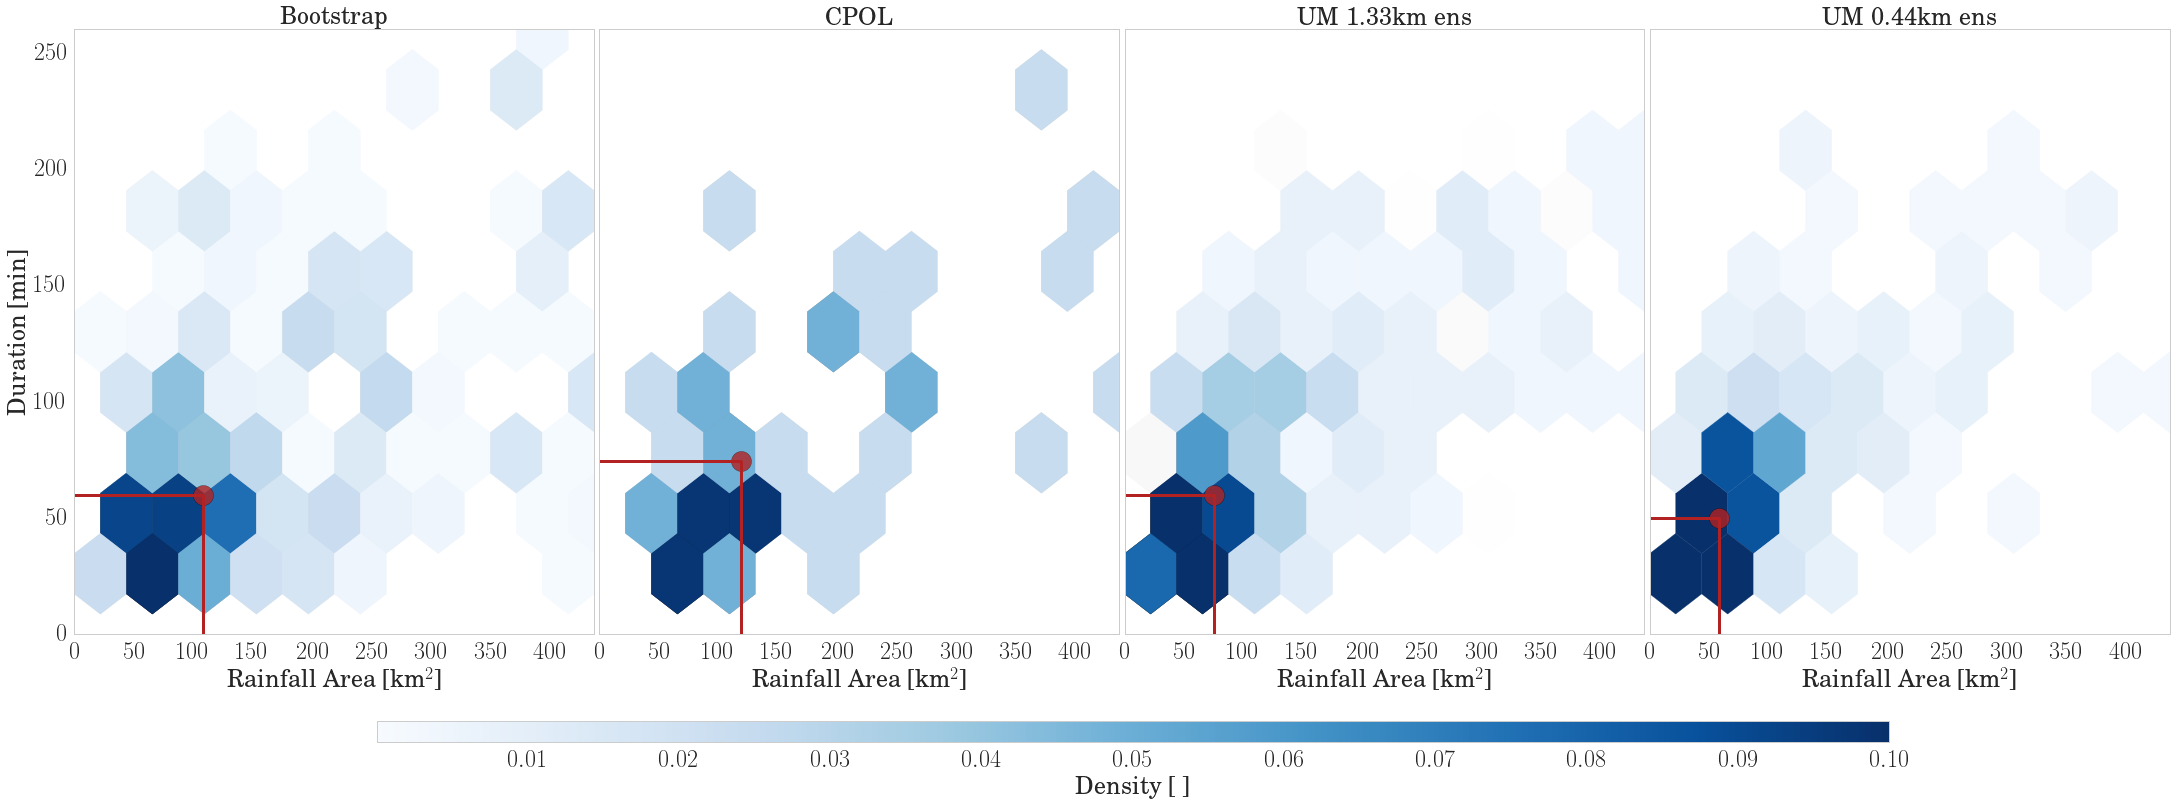

In [712]:
#Create Hex-Bin plot
mpld3.disable_notebook()
var=['avg_area','dur', 'max_mean', 'avg_mean']
medians = pd.DataFrame({ 'Bootstrap':CPOL_pdf[var].median(),
                        'CPOL':CPOL_pdf2[var].median(),
                        'UM 1.33km':UM133_pdf[var].median(),
                        'UM 0.44km':UM044_pdf[var].median()})
#medians.loc['avg_area'] /= 2.5**2
histdata =  [UM044_pdf[var].dropna(), UM133_pdf[var].dropna(), CPOL_pdf2[var].dropna(), CPOL_pdf[var]][::-1]
titles = ['UM 0.44km ens', 'UM 1.33km ens', 'CPOL', 'Bootstrap'][::-1]
fig = plt.figure(figsize=(10,8))
colm = colmap2.Blues
colm.set_under('w', alpha=0)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
fig.subplots_adjust(bottom=0.07, right=0.98, left=0.01, top=0.35, wspace=0.01)
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.01])
hexbin_data = []
gridsize = 10
vmin=0.0001
vmax=0.1
nticks=10
YMax, XMax = 260, 70*2.5**2
#YMax, XMax = 50, 70*2.5**2
for i, ax in enumerate((ax1, ax2, ax3, ax3)):
    data = histdata[i][var[:2]]
    #data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(0,YMax)
    ax.set_xlim(0,XMax)
    hb =  ax.hexbin(X, Y,  gridsize=gridsize, extent=(0,XMax,0,YMax))
    hexbin_data.append(np.ones_like(Y, dtype=np.float) / hb.get_array().sum())
    
plt.cla()
medians = OrderedDict()

for i, ax in enumerate((ax1, ax2, ax3, ax4)):
    data = histdata[i][var[:2]]
    #data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(0,YMax)
    ax.set_xlim(0,XMax)
    im = ax.hexbin(X, Y,  gridsize=gridsize, cmap=colm, marginals=False, extent=(0,XMax,0,YMax),
                     vmin=vmin, vmax=vmax, C=hexbin_data[i], reduce_C_function=np.sum)
    
    ax.set_title(titles[i], fontsize=24)
    ax.grid(color='w', linestyle='', linewidth=0)
    ax.tick_params(labelsize=24)
    ax.xaxis.set_ticks(ax.xaxis.get_ticklocs()[:-1])
    x, y = histdata[i][var[0]].median(), histdata[i][var[1]].median()
    z, zz=  histdata[i][var[2]].median(), histdata[i][var[-1]].median()
    sx, sy = histdata[i][var[0]].std(), histdata[i][var[1]].std()
    medians[titles[i]] = '%2.1f km^2, %2i min (max: %2.1f mm/h, mean: %2.1f mm/h);'%(x,y, z, zz)
    ax.hlines(y*np.ones_like(histdata[i][var[0]]),0,x, 'firebrick', lw=3)
    ax.vlines(x*np.ones_like(histdata[i][var[1]]),0,y, 'firebrick', lw=3)
    ax.scatter([x], [y], marker='o', s=400, c='firebrick', alpha=0.8)
    if i == 0:
        ax.set_ylabel('Duration [min]', fontsize=24)
    ax.set_xlabel('Rainfall Area [km$^2$]', fontsize=24)
ary=im.get_array()/im.get_array().sum() * 100
im.set_array = ary
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Density [ ]',size=24)
#cbar.set_ticks(np.linspace(vmin, vmax, nticks).round(2))
#cbar.set_ticklabels(np.linspace(vmin, vmax, nticks).round(2))
#print('Medians:')
#medians
#print(' '.join(['%s: %s'%(k, v) for (k,v) in medians.items()]))
plt.show()

In [696]:
colm = matplotlib_to_plotly(CubeYF_20.get_mpl_colormap(N=8, gamma=2.0),8, rgb=False)

### 3. Storm tracks above the 80th percentiles
* marks start of track, colors for different ensemble member

In [697]:
#Get the longest strom-tracks
data = OBS.dataset['obs'].to_dataframe().sort_values('dur')
data.loc[data.dur>100].sort_values('avg_mean')
time = CPOL_t.dataset['obs']['time'][:,str(42)]
lat, lon = CPOL_t.dataset['obs']['lat'][:,str(42)].values[0], CPOL_t.dataset['obs']['lon'][:,str(42)].values[0]
a = np.array([lat, lon])
start, end = time.values[0], time.values[-1]
sID = namedtuple('stormID', 'Sim')
storm_UM044 = sID(Sim={})
storm_UM133 = sID(Sim={})
for Id, um in ((storm_UM044, UM044_t), (storm_UM133, UM133_t)):
    for ens, data in um.dataset.items():
        idx = np.unique((data['time'] - start).abs().sort_values()[:20].index.get_level_values('uid')).astype('i')
        d = []
        for uid in idx.astype('str'):
            b = np.array([data['lat'][:,uid].values[0], data['lon'][:,uid].values[0]])
            r = np.linalg.norm(a-b)
            d.append([uid.astype('i'), r])
        d = int(np.array(d).min(axis=0)[0])
        Id.Sim[ens]=str(d)
storm_obs=sID(Sim={'obs':'42'})

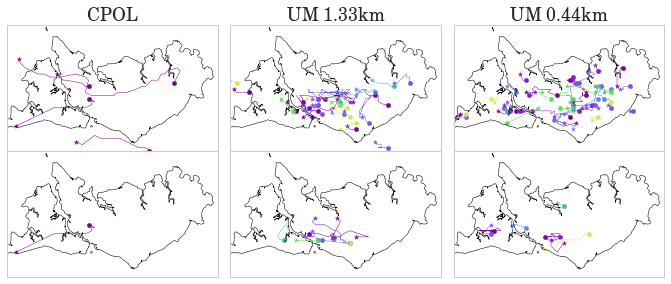

In [588]:
#Plot the tracks
mpld3.enable_notebook()
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(right=0.94, bottom=0.45, top=0.95,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
o = namedtuple('Sim', 'dataset percentiles')
tmp_obs = o({'obs': CPOL_t.dataset['obs']}, {'obs': CPOL_t.percentiles['obs']})

with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
m = None
for i, data in enumerate(((tmp_obs, storm_obs), (UM133_t, storm_UM133), (UM044_t, storm_UM044))):
    tracks, stormId = data
    ax = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    ax.set_title(titels[i], fontsize=18)
    for ii, tr in enumerate(tracks.dataset.keys()):
        if ii == 0:
            draw_map = None
            m2 = None
        else:
            draw_map = m
        Id = [stormId.Sim[tr]]
        perc = tracks.percentiles[tr][tp][num]
        ax, m, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh_val=perc, thresh='mean', 
                  color=colm[ii], draw_map=draw_map, basemap_res='f', lw=0.5, size=20, particles=None)
        ax2, m2, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax2, mintrace=2, thresh_val=-1, thresh='mean', 
                  color=colm[ii], draw_map=m2, basemap_res='f', lw=0.5, size=20, particles=Id)
        #break
plt.show()

In [589]:
#Plot the tracks
#fig = plt.figure(figsize=(25,15))
#fig.subplots_adjust(right=0.94, bottom=0.025, top=0.67,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
data = []
layout =dict(autosize = False)
domains = [[0,.3], [0.33, 0.63], [0.66,0.99]]
ii = 0
data = []
#fig['layout'].update(height=600, width=600,
#fig = tools.make_subplots(rows=1, cols=3, subplot_titles=Titles)
for i, tracks in enumerate((CPOL_t, UM133_t, UM044_t)):
    #ax = fig.add_subplot(1,3,i+1)
    #for tr in tracks.dataset.keys():
    name = 'geo'+str(ii+1) if ii != 0 else 'geo'
    layout[name] = dict(
        domain = dict(x=domains[i], y=[0,1]),
        resolution=50,
        lonaxis =  dict(range = [min(lon), max(lon)]),
        lataxis = dict(range = [min(lat), max(lat)]),
        projection=dict( type='azimuthal equal area', scale=1 ),
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)')
    if ii == 0 or ii == 1 or ii == 15:
         text = [titels[i]]
    else:
        text = None
            
    perc = tracks.percentiles[tr][tp][num]
    data += get_plotly_traj(tracks.dataset[tr], thresh_val=perc, thresh='mean',
                                    geo=name, mintrace=2, text=text,showlegend = False)
    ii += 1
    #plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh_val=perc, thresh='mean')
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='storm-tracks' )

KeyError: '20061110T0000Z'

In [720]:
#mpld3.disable_notebook()
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'Bootstrp')

CPOL_pdf2 = ravel(OBS.dataset['obs'])
df_stack = pd.concat([CPOL_pdf2, UM133_pdf, UM044_pdf], ignore_index=True)
#df_stack['avg_area'] /= 2.5**2
df_stack['avg_area'].loc[(df_stack['quant']==3) & (df_stack['run']=='Cpol')] /= 1
df_stack['dur'].loc[(df_stack['quant']==4) & (df_stack['run']=='Cpol')] *= 1
#df_stack['quant'] = df_stack['quant'].astype('i')


###  4. Classification of strom area, rain-rate and duration by rain-rate quintiles

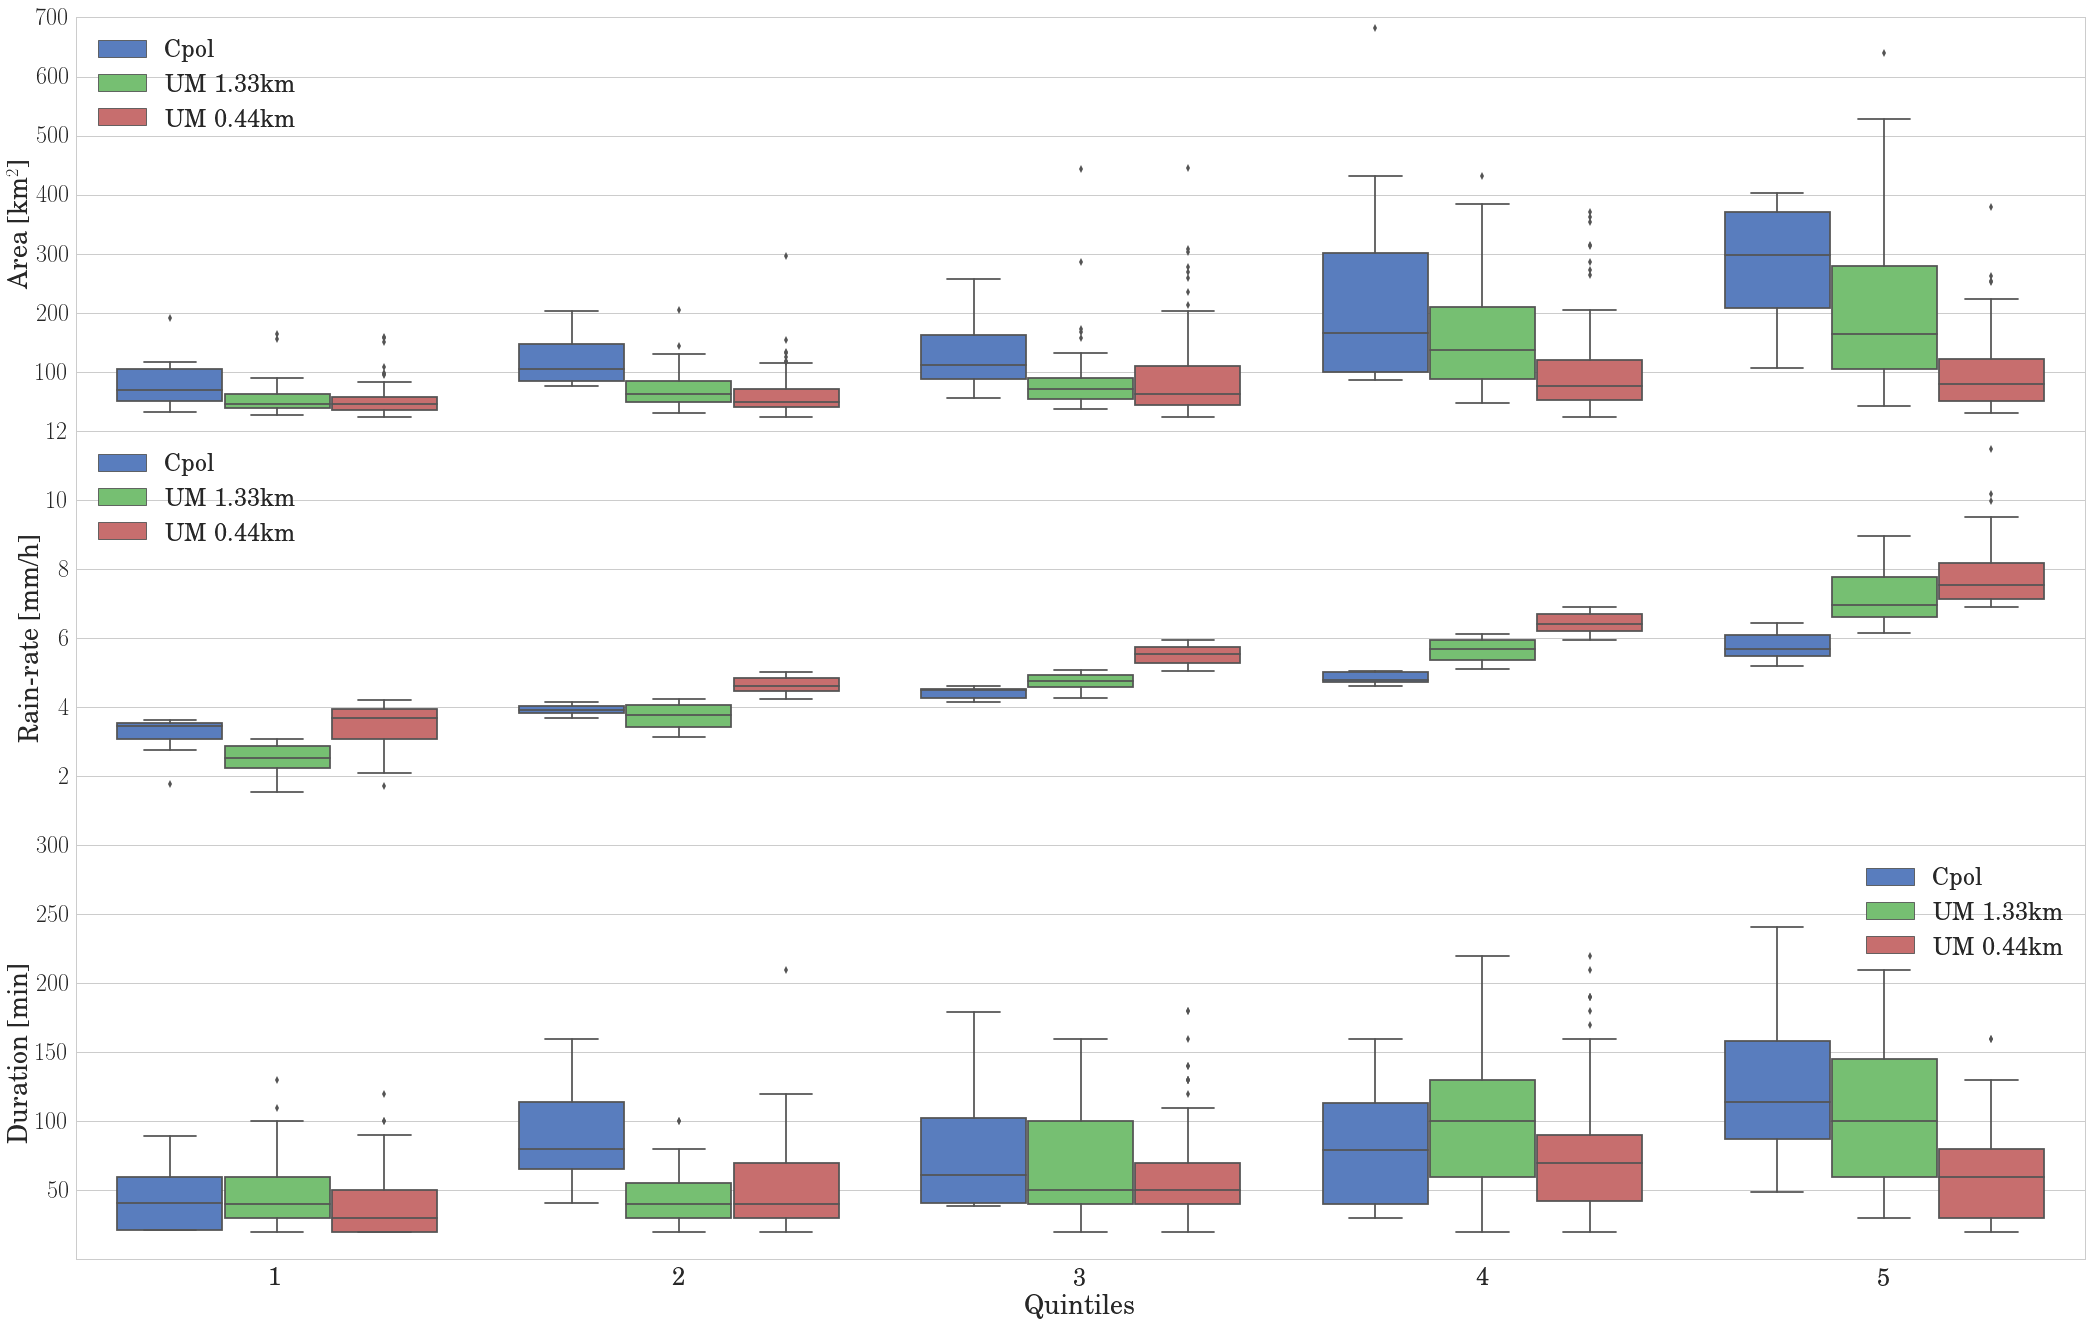

In [721]:
mpld3.disable_notebook()
variables=dict(dur=('Duration [min]',300), avg_area=('Area [km$^2$]', 100*2.5**2), avg_mean=('Rain-rate [mm/h]',12))
fig = plt.figure()
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.6,left=0.01, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    ax = sns.boxplot(x="quant", y=y, hue="run", data=df_stack, palette="muted", ax=ax)
    #ax = sns.stripplot(x="quant", y=y, hue="run", data=df_stack, jitter=True, palette="Set2", dodge=True)
    ax.legend(loc=0, fontsize=24)
    ax.tick_params(labelsize=24)
    ax.set_xlim(0.5,5.5)
    ax.set_ylim(0,ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=26)
    ax.set_ylabel(label, fontsize=26)

### 5. Stormtrack Percentiles vs Rain-rate

In [718]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
member=[]
for i in range(4):
    o = OBS.dataset['m%02i'%i]['avg_mean'].values.ravel()
    member.append(np.percentile(o, P))
member=np.array(member)
mem_min = member.min(axis=0)
mem_max = member.max(axis=0)

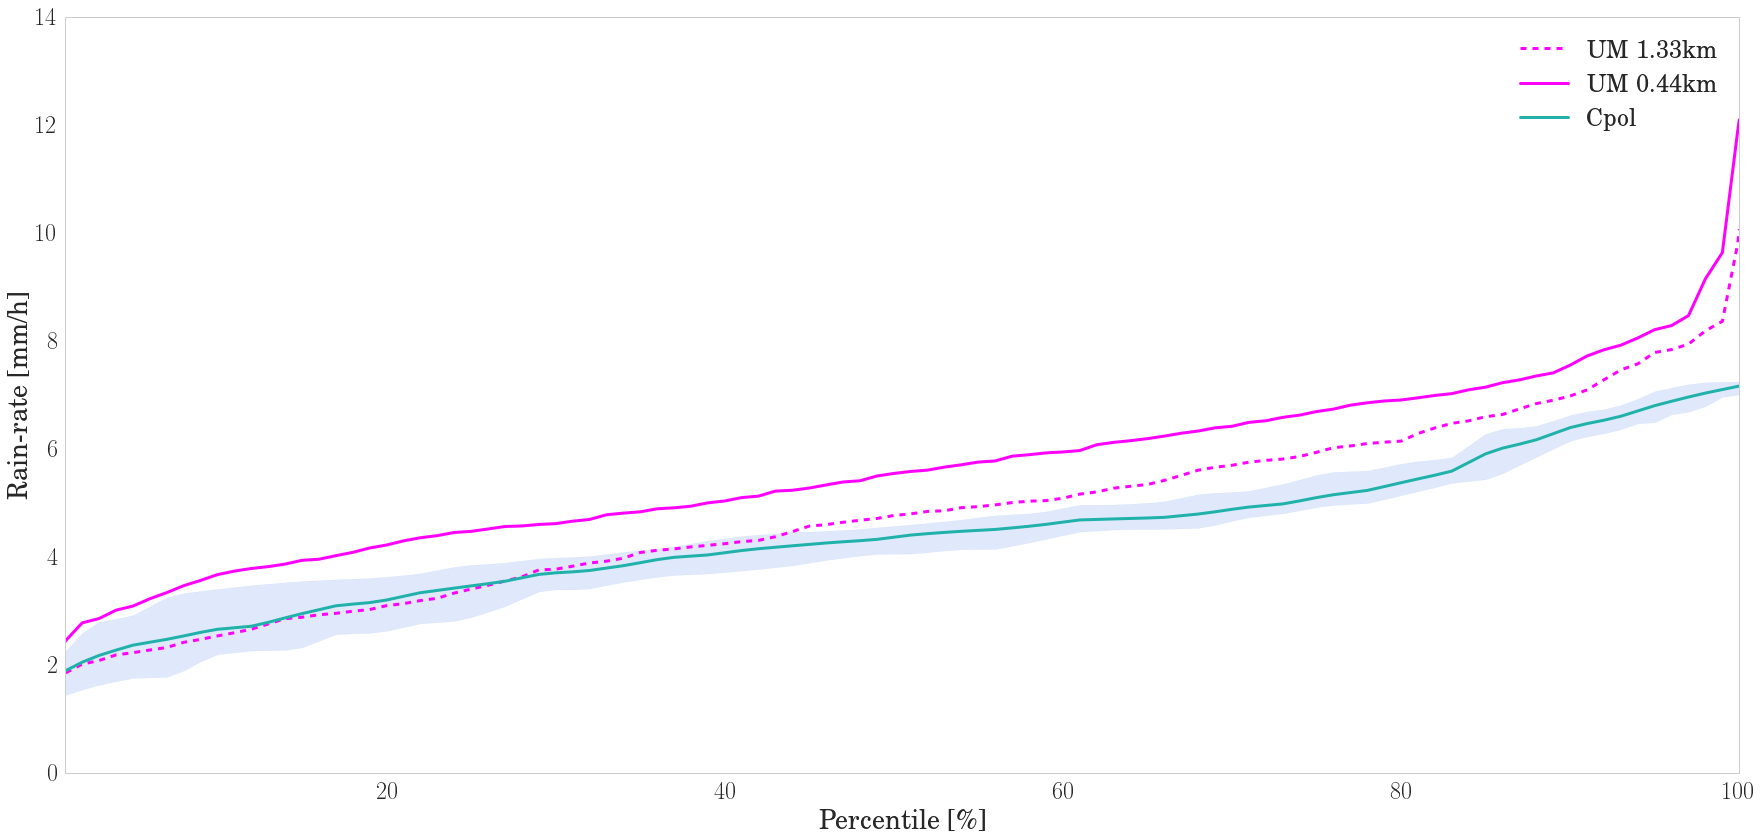

In [722]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]

PERC = pd.DataFrame({'Obs':np.percentile(CPOL_pdf2['avg_mean'].values, P), 
                     'UM 1.33km': np.percentile(UM133_pdf['avg_mean'].values, P),
                      'UM 0.44km': np.percentile(UM044_pdf['avg_mean'].values, P)},index=P)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
#Plot the percentages
fig=plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.05, right=0.9, top=0.4)
#ax.plot(PERC.index, PERC['Obs'].values, color='lightseagreen', linestyle='-', label='CPOL',lw=3)
ax.plot(PERC.index, PERC['UM 1.33km'].values, color='fuchsia', linestyle='--', label='UM 1.33km',lw=3)
ax.plot(PERC.index, PERC['UM 0.44km'].values, color='fuchsia', linestyle='-', label='UM 0.44km', lw=3)
ax.fill_between(PERC.index, member.min(axis=0), member.max(axis=0), color='cornflowerblue', alpha=0.2)
ax.plot(PERC.index, member.mean(axis=0), color='lightseagreen', linestyle='-', label='Cpol',lw=3)
ax.set_xlim(1,100)
#ax.set_ylim(10,100)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Percentile [\%]', fontsize=26)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=26)
ax.legend(loc=0, fontsize=24)
ax.tick_params(labelsize=24)
ax.grid(color='r', linestyle='-', linewidth=0)

In [595]:
#Bootstrapping stuff:


### 7. Individual Cases (12/11 2006)

In [597]:
#Read the Simulation data
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
## First define the file names of the simulations
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z', '20061110T0600Z', '20061110T1200Z',
             '20061110T1800Z',  '20061111T0000Z', '20061111T1200Z')
Simend = '20061119_0600-%s'%remap_res
### Define the resolutions we have with help of a named tuple
gridded = namedtuple('Simulation', 'member dataset resolution')
UM133_grid = gridded(member=ensembles, dataset=[], resolution=1.33)
UM044_grid = gridded(member=ensembles, dataset=[], resolution=0.44)
OBS_grid = gridded(member=['CPOL'], dataset=[], resolution=2.55)
# Now construct the filenames of the UM - rainfall ouput and get the overlapping time periods
start, end = [], []
for ens in ensembles:
    date = datetime.strptime(ens,'%Y%m%dT%H%MZ')
    umf133 = 'um-1p33km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    umf044 = 'um-0p44km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    time133 = xr.open_dataset(os.path.join(UMdir,ens,'darwin','1p33km', umf133)).coords['t'].values
    time044 = xr.open_dataset(os.path.join(UMdir,ens,'darwin','0p44km', umf044)).coords['t'].values
    start.append((time133[0], time044[0]))
    end.append((time133[-1], time044[-1]))
end = np.min(np.array(end), axis=0)
start = np.max(np.array(start), axis=0)
# Now get the datasets for these overlapping time periods
for nn, ens in enumerate(ensembles):
    date = datetime.strptime(ens,'%Y%m%dT%H%MZ')
    umf133 = 'um-1p33km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    umf044 = 'um-0p44km-%s-rain_%s-%s.nc' %(date.strftime('%m%d%H%M'), date.strftime('%Y%m%d_%H%M'), Simend)
    for file, res, ntuple, n in ((umf133, '1p33km', UM133_grid, 0), (umf044, '0p44km', UM044_grid, 1)):
        fn = os.path.join(UMdir, ens,'darwin', res, file)
        with xr.open_dataset(fn) as ds:
            um_times = pd.DatetimeIndex(ds.coords['t'].values).round('1min')
            iloc_s = abs(um_times - pd.Timestamp(start[n])).argmin()
            iloc_e = abs(um_times - pd.Timestamp(end[n])).argmin()
            
        ntuple.dataset.append(xr.open_dataset(fn).isel(t=list(range(iloc_s,iloc_e+1)), surface=[0]))
        ntuple.dataset[-1].coords['t'] = um_times[iloc_s:iloc_e+1].round('5min')
# Now get the overlapping time periods for the observations


for nn,file in enumerate((WOHF, WOHFv1, CMORPHF, WOHFv2)):
    with nc(file) as ds:
        obs_time = pd.DatetimeIndex(num2date(ds.variables['t'][:], ds.variables['t'].units))
        iloc_s = abs(obs_time - pd.Timestamp(start[0])).argmin()
        iloc_e = abs(obs_time - pd.Timestamp(end[0])).argmin()

    ds = xr.open_dataset(file)
    ds.coords['t'] = obs_time
    if nn > 0:
        try:
            slon = np.fabs(ds.variables['longitude'].values[0,:] - min(lon)).argmin()
            elon = np.fabs(ds.variables['longitude'].values[0,:] - max(lon)).argmin()+1
            slat = np.fabs(ds.variables['latitude'].values[:,0] - min(lat)).argmin()
            elat = np.fabs(ds.variables['latitude'].values[:,0]- max(lat)).argmin()+1
        except IndexError:
            slon = np.fabs(ds.variables['longitude'].values[:] - min(lon)).argmin()
            elon = np.fabs(ds.variables['longitude'].values[:] - max(lon)).argmin()+1
            slat = np.fabs(ds.variables['latitude'].values[:] - min(lat)).argmin()
            elat = np.fabs(ds.variables['latitude'].values[:]- max(lat)).argmin()+1
        try:
            OBS_grid.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1)), y=range(slon,elon), x=range(slat,elat)))
        except ValueError:
            OBS_grid.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1)), longitude=range(slon,elon), latitude=range(slat,elat)))
    else:
        OBS_grid.dataset.append(ds.isel(t=list(range(iloc_s, iloc_e+1))))
UM133ens_grid = xr.concat(UM133_grid.dataset, dim='ens')
UM044ens_grid = xr.concat(UM044_grid.dataset, dim='ens')

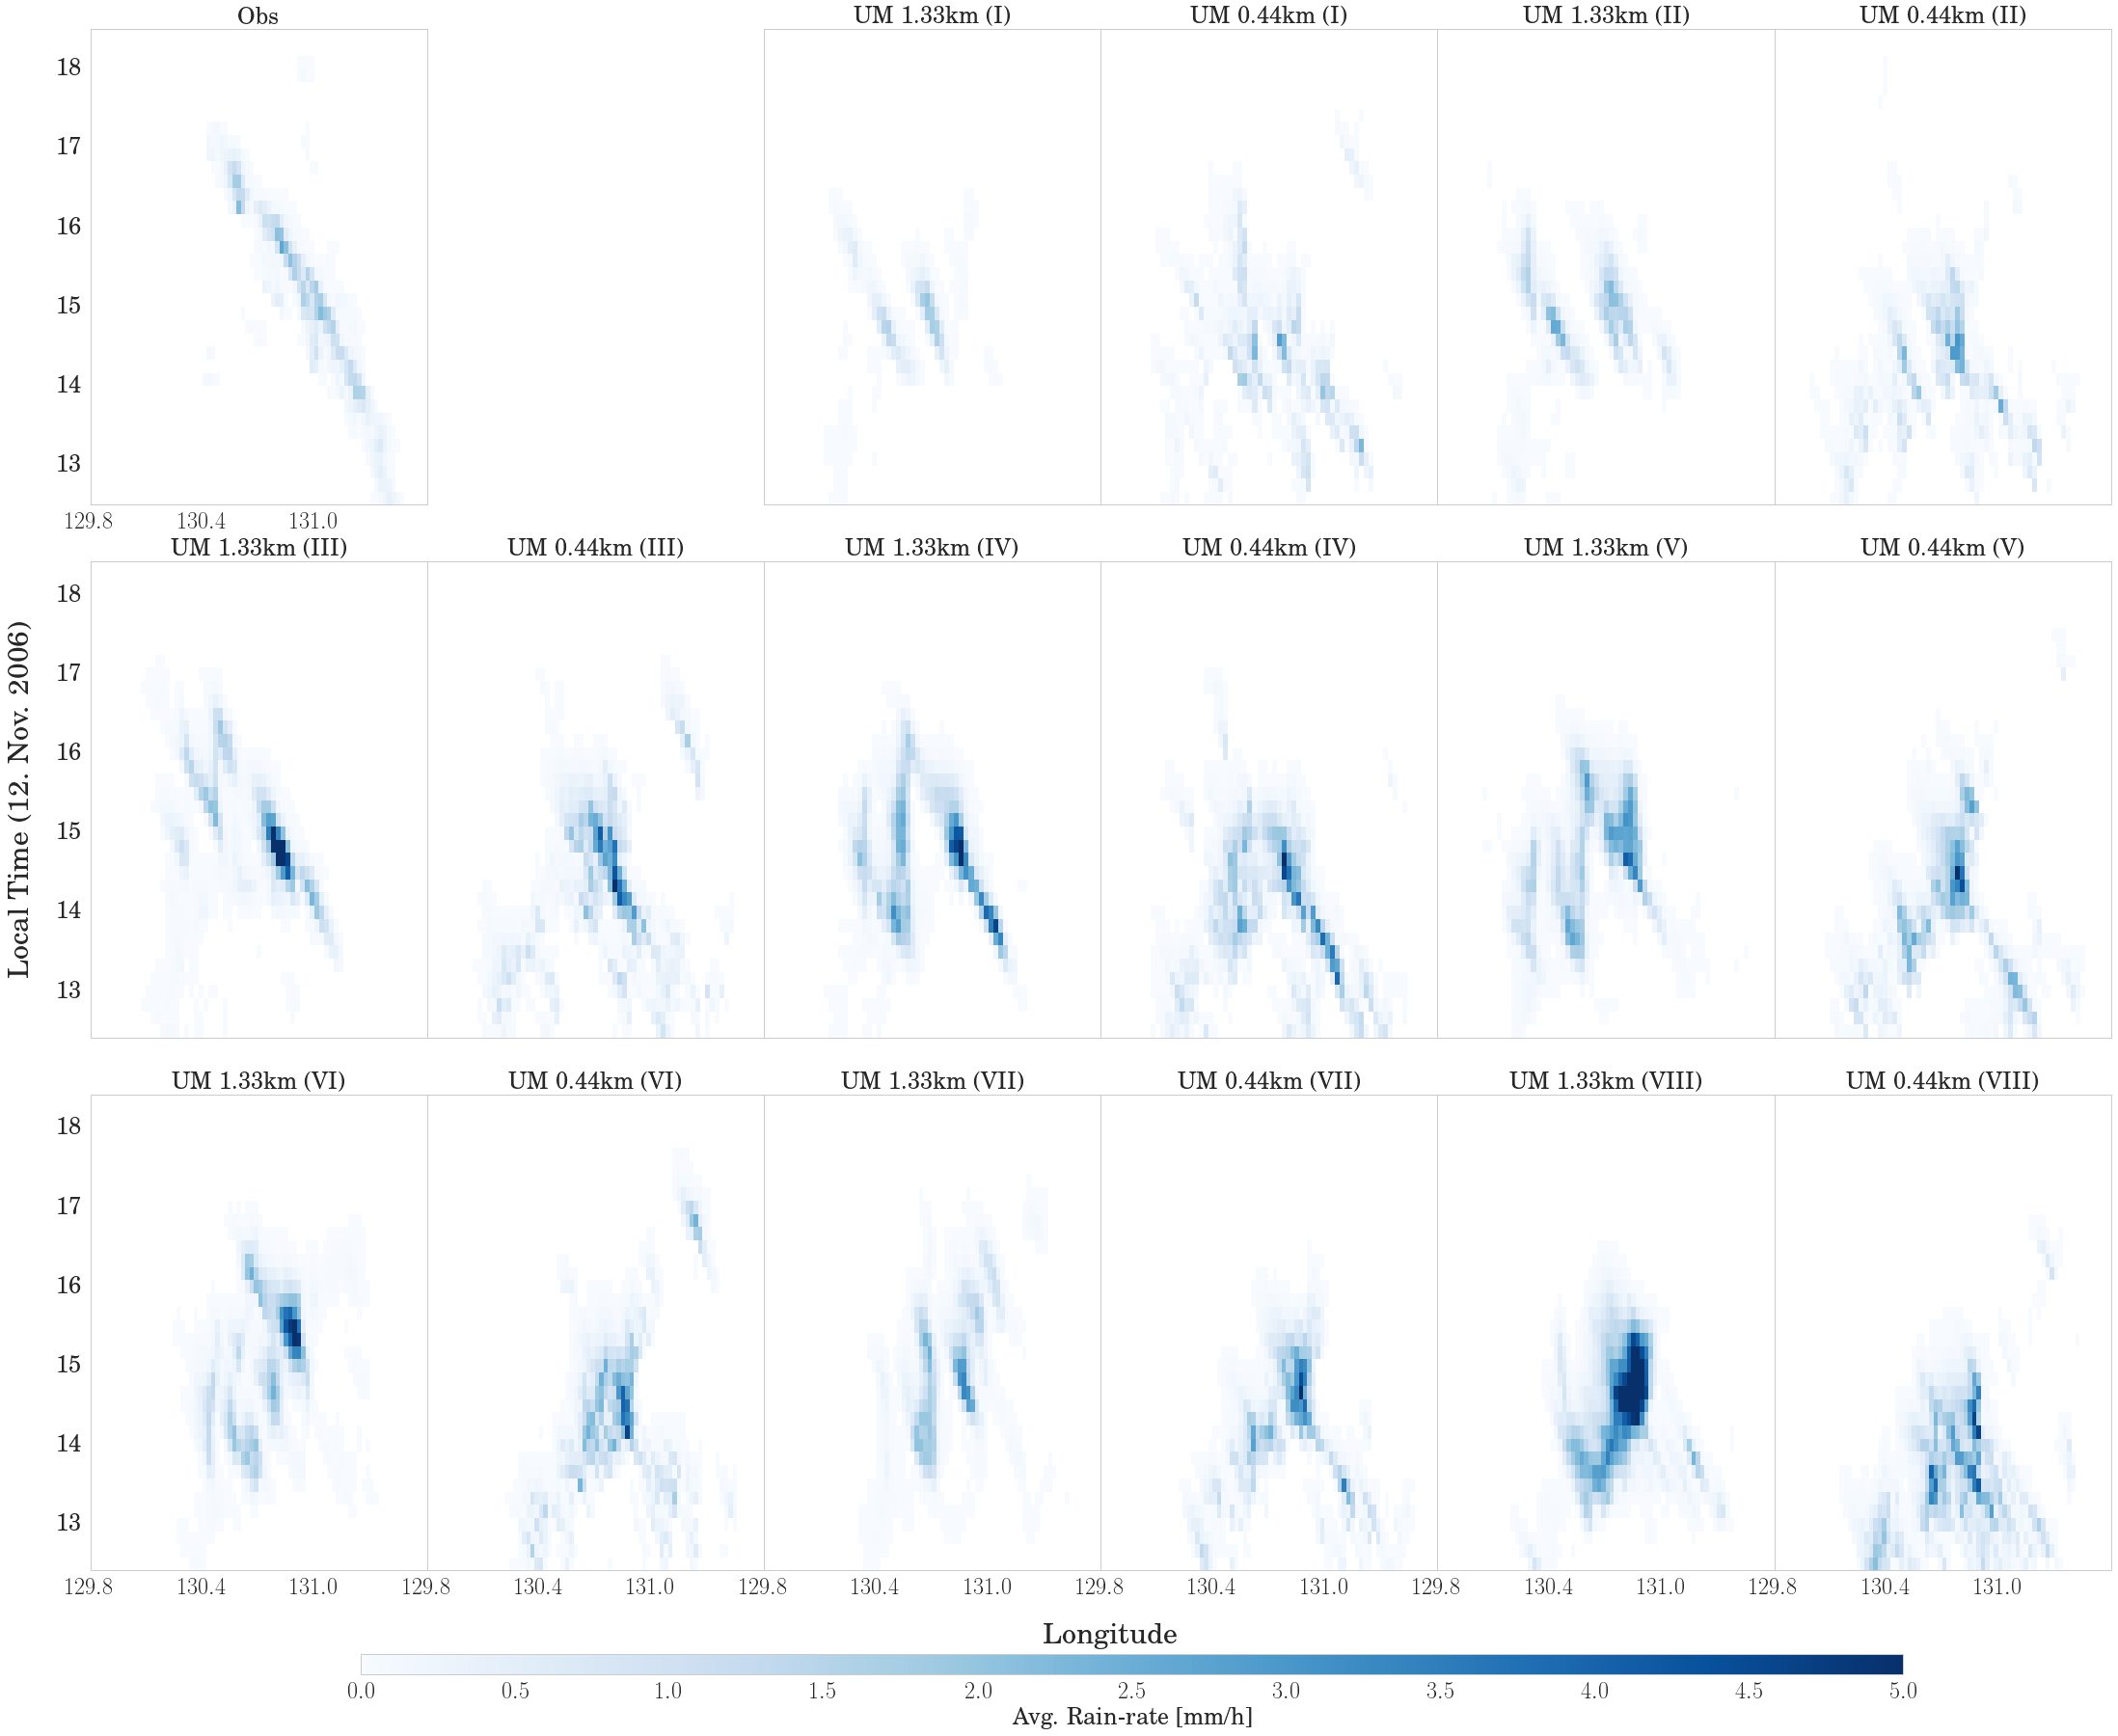

In [598]:
#Now make a hovemoller plot of the date
mpld3.disable_notebook()
cmap = colmap2.Blues
cmap.set_under('w')
cmap.set_bad('w')
import matplotlib.gridspec as gridspec
from itertools import product

## Define start and end time
start_time = pd.DatetimeIndex([datetime(2006,11,12,12,0, tzinfo=timezone)])[0]
end_time = pd.DatetimeIndex([datetime(2006,11,12,18,0, tzinfo=timezone)])[0]
hfmt = dates.DateFormatter('%H')
## Get the information for cpol obs
dy1 = len(OBS_grid.dataset[1].coords['x'])//2
obs = OBS_grid.dataset[1].variables['lsrain'][...,:-20,:].mean(dim=('x'))
obs_tsteps = pd.DatetimeIndex(OBS_grid.dataset[1].coords['t'].values).tz_localize(utc).tz_convert(timezone)
obs_lon = OBS_grid.dataset[1].variables['longitude'][0,:]
sIdx = np.fabs((obs_tsteps - start_time).total_seconds().values).argmin()
eIdx = np.fabs((obs_tsteps - end_time).total_seconds().values).argmin()+1
obs_tsteps = obs_tsteps[sIdx:eIdx]
obs_data = np.ma.masked_less_equal(obs[sIdx:eIdx].values, 0.000)
#sIdx, eIdx = 0, -1

## Get the information from the simulations
### 044 SIM
dy1 = len(UM044ens_grid.coords['lat'])//2
um_tsteps1 = pd.DatetimeIndex(UM044ens_grid.coords['t'].values).tz_localize(utc).tz_convert(timezone) 
um1 = UM044ens_grid.variables['lsrain'][...,:-20,:].mean(dim=('lat','surface'))
sIdx = np.fabs((um_tsteps1 - start_time).total_seconds().values).argmin()
eIdx = np.fabs((um_tsteps1 - end_time).total_seconds().values).argmin()+1
um_data1 = np.ma.masked_less_equal(um1[:,sIdx:eIdx].values, 0.00)
um_lon1 = UM044ens_grid.coords['lon'][:]
um_tsteps1 = um_tsteps1[sIdx:eIdx]
tit = ['Obs']
## 133 SIM
dy1 = len(UM133ens_grid.coords['lat'])//2
um_tsteps2 = pd.DatetimeIndex(UM133ens_grid.coords['t'].values).tz_localize(utc).tz_convert(timezone) 
um2 = UM133ens_grid.variables['lsrain'][...,:-20,:].mean(dim=('lat','surface'))
sIdx = np.fabs((um_tsteps2 - start_time).total_seconds().values).argmin()
eIdx = np.fabs((um_tsteps2 - end_time).total_seconds().values).argmin()+1
um_data2 = np.ma.masked_less_equal(um2[:,sIdx:eIdx].values, 0.00)
um_lon2 = UM133ens_grid.coords['lon'][:]
um_tsteps2 = um_tsteps2[sIdx:eIdx]
## Stack the simulations together
um_data = [(um_data2, um_lon2, um_tsteps2) , (um_data1, um_lon1, um_tsteps1)]

#fig, ax = plt.subplots(3,3, sharey=True, sharex=True)
fig = plt.figure()
#ax=ax.ravel()


outer_grid = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.12)
inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[0], wspace=0.0, hspace=0.0)
ax = plt.Subplot(fig, inner_grid[0])
im = ax.pcolormesh(obs_lon, obs_tsteps.tz_localize(None), obs_data,vmin=0.0,vmax=5,cmap=cmap)

fig.add_subplot(ax)

ax.set_title('Obs', fontsize=24)
ax.tick_params(labelsize=24)
ax.xaxis.set_ticks(list(ax.xaxis.get_ticklocs()[:-1][::3]))
#ax.set_ylabel('Local Time', fontsize=28)
ax.yaxis.set_major_formatter(hfmt)
add = ('UM 1.33km', 'UM 0.44km')
for i in range(1,9):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
    for j, data in enumerate(um_data):

        um, lon, tsteps = data
        ax = plt.Subplot(fig, inner_grid[j])
        m = ax.pcolormesh(lon, tsteps.tz_localize(None), um[i-1],vmin=0.0,vmax=5,cmap=cmap)
        if i in (8,7,6):
            ax.tick_params(labelsize=24)
            ticks =[' ']+list(ax.xaxis.get_ticklocs()[1:][::3].round(1).astype(str))
            #ax.xaxis.set_ticks(ticks)
            ax.xaxis.set_ticks(list(ax.xaxis.get_ticklocs()[:-1][::3]))
        else:
            ax.set_xticks([])
        tit = add[j]+ r' (\rom{{{}}})'.format(i)
        #tit = add[j]+datetime.strptime(ensembles[i-1], '%Y%m%dT%H%MZ').strftime(' (%e %b %H UTC)')
        #if j == 0:
            
        if i == 3 or i == 6:
            if j == 0:
                #ax.set_ylabel('Local Time', fontsize=28)
                ax.tick_params(labelsize=24)
                ax.yaxis.set_major_formatter(hfmt)
            else:
                ax.set_yticks([])
        else:
            ax.set_yticks([])
        ax.set_title(tit, fontsize=24)


        fig.add_subplot(ax)
fig.subplots_adjust(right=0.98, bottom=0.25, top=0.99,left=0.01, hspace=0.1, wspace=0)
cbar_ax = fig.add_axes([0.14, 0.20, 0.74, 0.01])
cbar=fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Avg. Rain-rate [mm/h]',size=24)
fig.text(0.5, 0.215, 'Longitude', ha='center', fontsize=30)
fig.text(-0.03, 1-0.38, 'Local Time (12. Nov. 2006)', va='center', rotation='vertical', fontsize=30)
#for i in (6, 7, 8):
#    ax[i].set_xlabel('Longitude', fontsize=28)

In [599]:
def get_tracks_from_dates(trackset, start, end, tz):
    track_times = pd.DatetimeIndex(trackset.time).tz_localize(utc).tz_convert(tz)
    ts = np.fabs((track_times - start_time).total_seconds()).argmin()
    te = np.fabs((track_times - end_time).total_seconds()).argmin()+1
    tt = track_times[ts:te].tz_convert(utc).tz_convert(None)
    return trackset.loc[(trackset.time >= tt[0]) & (trackset.time <= tt[-1])]
UM133_trackData = gridded(member=ensembles, dataset=[], resolution=1.33)
UM044_trackData = gridded(member=ensembles, dataset=[], resolution=0.44)
#CPOL_trackData =  gridded(member=[obs], dataset=[None], resolution=2.5)
CPOL_trackData = get_mean(get_tracks_from_dates(CPOL_t.dataset['obs'], start_time, end_time, timezone))
for df, target in ((UM044_t, UM044_trackData), (UM133_t, UM133_trackData)):
    for ens in df.dataset.values():
        target.dataset.append(get_mean(get_tracks_from_dates(ens, start_time, end_time, timezone)))

UM133_trackData = xr.concat(UM133_trackData.dataset, dim='ens')
UM044_trackData = xr.concat(UM044_trackData.dataset, dim='ens')

In [600]:
dataset = get_tracks_from_dates(CPOL_t.dataset['obs'], start_time, end_time, timezone)
df = dataset.xs(str(30), level='uid')
path = df[['lon','lat']].values
d = np.array([dist(path[i], path[i+1]) for i in range(0,len(df)-1,2)])

In [601]:
um044_n = len(UM044_trackData.coords['dim_0'])
um133_n = len(UM133_trackData.coords['dim_0'])
cpol_n = len(CPOL_trackData.coords['dim_0'])

cpol_d = round(CPOL_trackData.to_dataframe()['dist'].max(),2)*2
um044_d = np.array(UM044_trackData['dist'].max(axis=1).median()).round(2)*1.5
um133_d = np.array(UM133_trackData['dist'].max(axis=1).median()).round(2)*1.5


var=['avg_area','dur', 'dist', 'avg_mean', 'max_mean']
names=['area', 'duration', 'distance', 'avg-rain', 'max-rain', 'distance','# storms']
#print(CPOL_pdf[var].median())
medians = pd.DataFrame({'b': list(CPOL_trackData[var].to_dataframe().median().values.round(2))+[cpol_d,int(cpol_n)],
                        'd': list(UM044_trackData[var].to_dataframe().median().values.round(2))+[um044_d,int(um044_n)],
                        'c': list(UM133_trackData[var].to_dataframe().median().values.round(2))+[um133_d,int(um133_n)]} )
                       #index=('Area','Duration', 'Mean-Rain', 'Max-Rain'))
medians.index=names
medians.columns=['Cpol', 'UM 1.33km', 'UM 0.44km']
#print('Medians:')               
medians.round(2)

Cpol  UM 1.33km  UM 0.44km
area       99.31      83.37      58.33
duration  121.60      70.00      50.00
distance   41.81      29.09      22.83
avg-rain    4.69       5.47       6.21
max-rain    7.09       7.86      10.21
distance  189.40     110.23      87.02
# storms    3.00       5.00       7.00